<a href="https://colab.research.google.com/github/victorm0202/OP-2020-code/blob/master/grad_cam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM class activation visualization

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/26<br>
**Last modified:** 2020/05/14<br>
**Description:** How to obtain a class activation heatmap for an image classification model.

Basado en F. Chollet y la actualización para TF 2.X 

## Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Cursos/optativa_2020/')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm



## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` and `classifier_layer_names`, use
 `model.summary()` to see the names of all layers in the model.


In [ ]:
model_builder = keras.applications.xception.Xception
# Make model
model = model_builder(weights="imagenet")
model.summary()

91889664/91884032 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

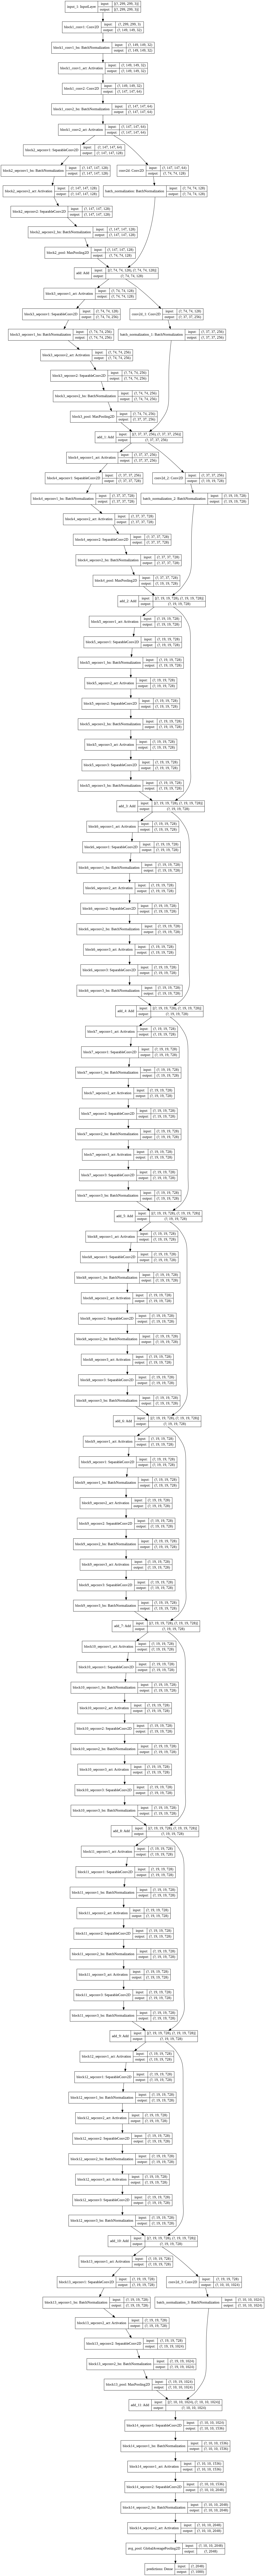

In [ ]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='figs/xception.png',show_shapes=True, show_layer_names=True)
Image(retina=True, filename='figs/xception.png')

In [ ]:
img_size = (299, 299, 3) #(u,v,channels)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = ["avg_pool", "predictions",]

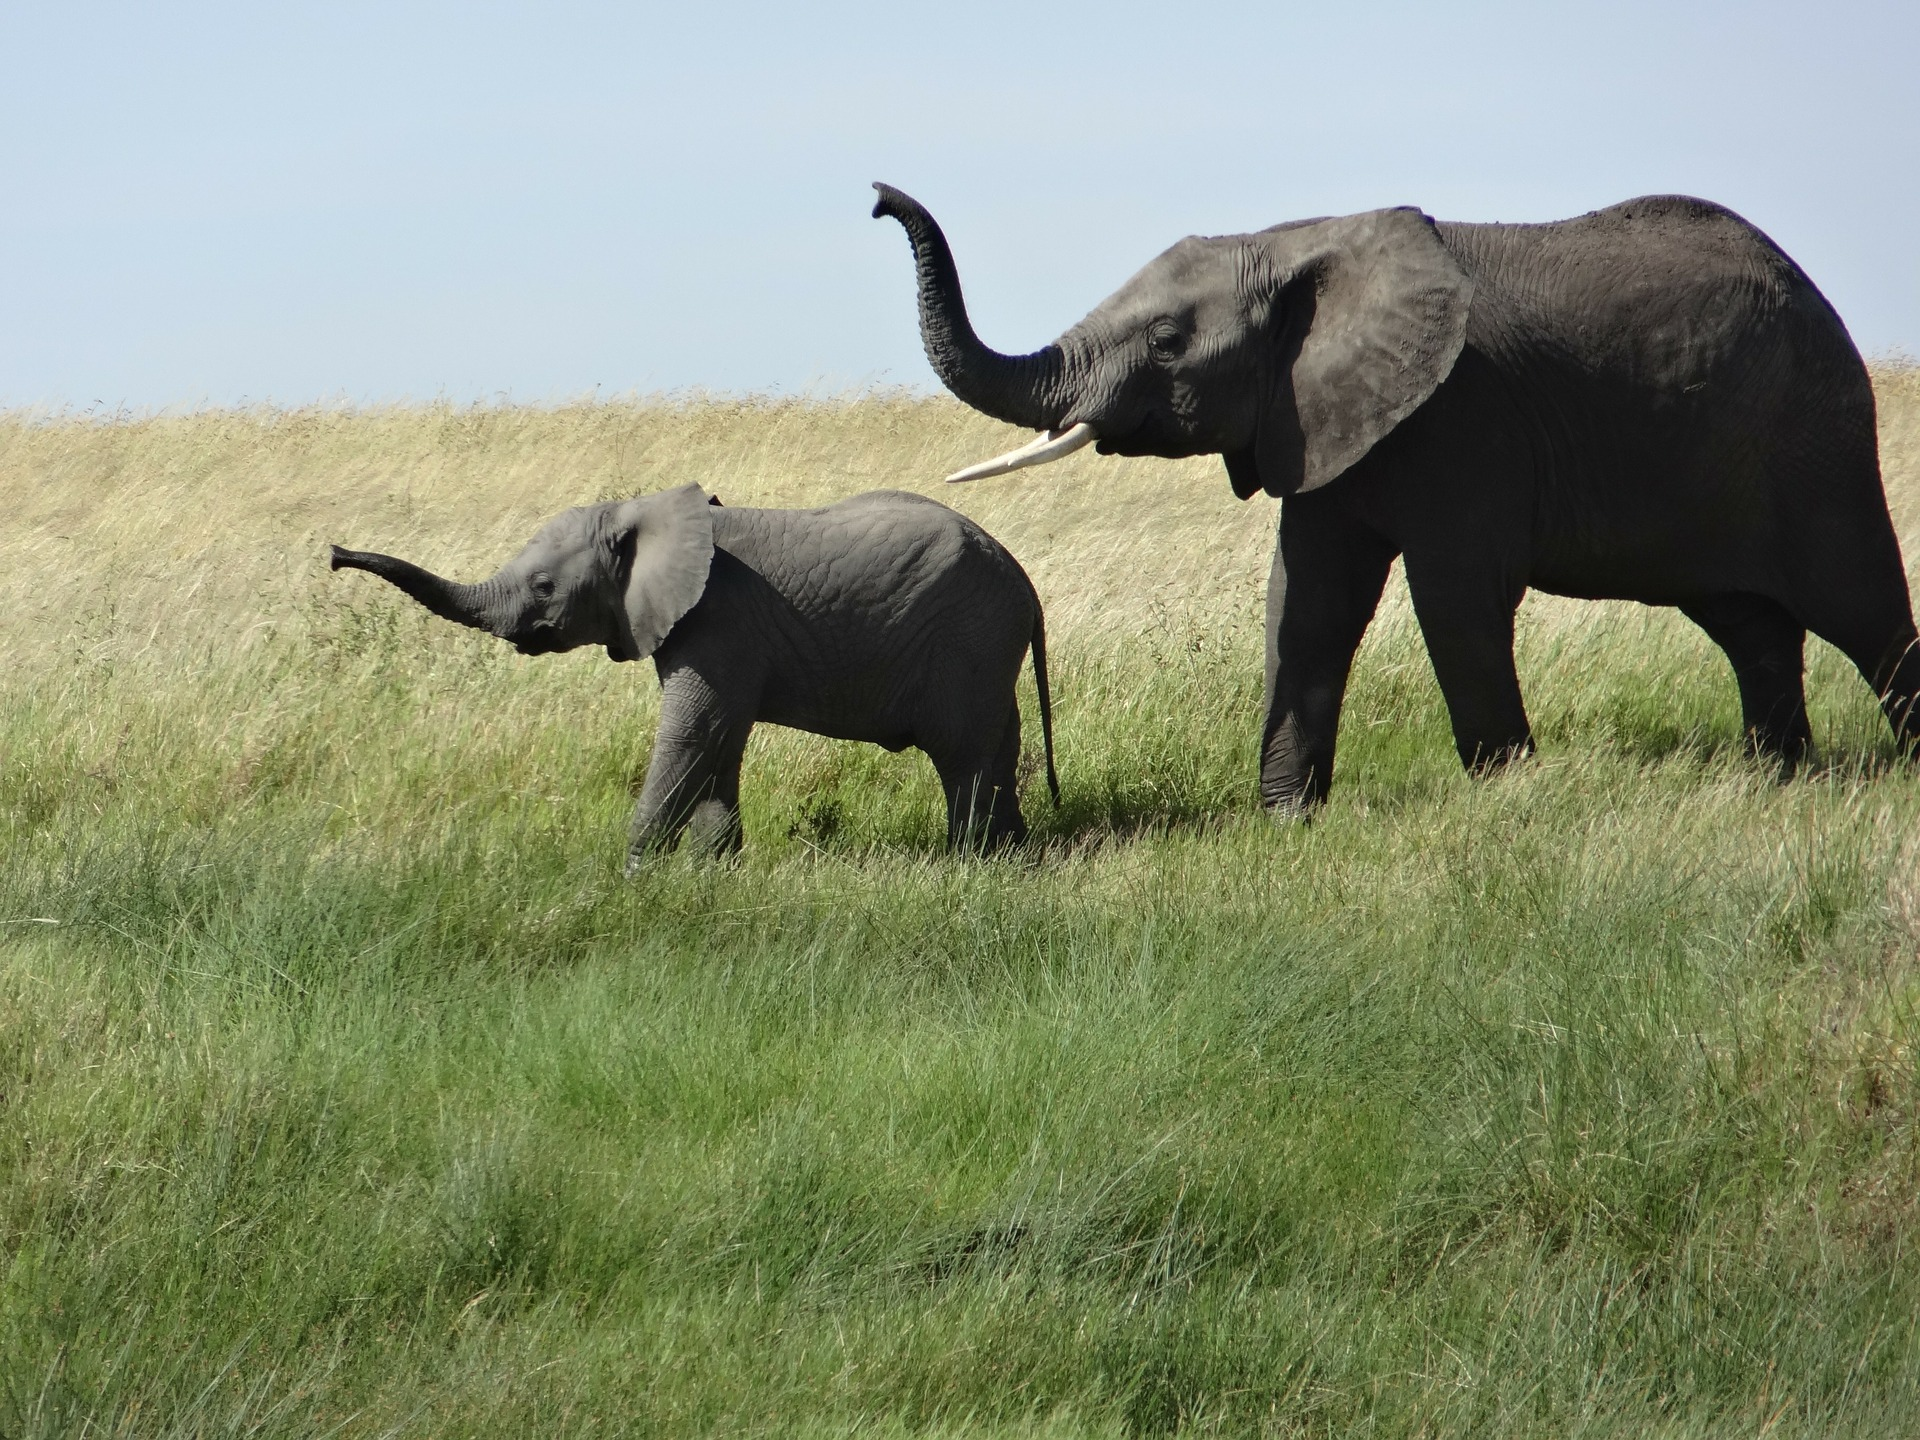

In [ ]:
# The local path to our target image
img_path = keras.utils.get_file("/content/drive/My Drive/Cursos/optativa_2020/figs/african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png")
display(Image(img_path))

## The Grad-CAM algorithm


In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size u x v
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (u,v, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name) # obtiene la ultima capa convolucional segun el nombre que especificamos antes
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output) 

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:]) # crea el tensor de entrada del tamaño especificao en la última capa de convolución
    x = classifier_input #inicializa
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x) #agrega capas con keras functional API...
    classifier_model = keras.Model(classifier_input, x) #el modelo final, básicamente reproduce la última parte del VGG16

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



## Let's test-drive it


In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)
dec_pred = decode_predictions(preds, top=5)[0]
print("Predicted:")
print("{:10} {:20} {:10}".format('Id. class', 'Class name', 'Probability'))
print(50*'-')
for decoded in dec_pred:
    print("{:10s} {:25s} {:0.5}".format(decoded[0], decoded[1], decoded[2]))

40960/35363 [==================================] - 0s 0us/step
Predicted:
Id. class  Class name           Probability
--------------------------------------------------
n02504458  African_elephant          0.88714
n01871265  tusker                    0.050588
n02504013  Indian_elephant           0.011149
n02172182  dung_beetle               0.00029058
n02391049  zebra                     0.00026998


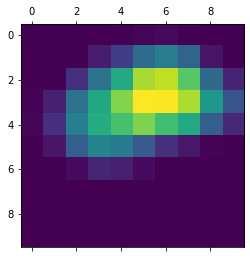

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Create a superimposed visualization


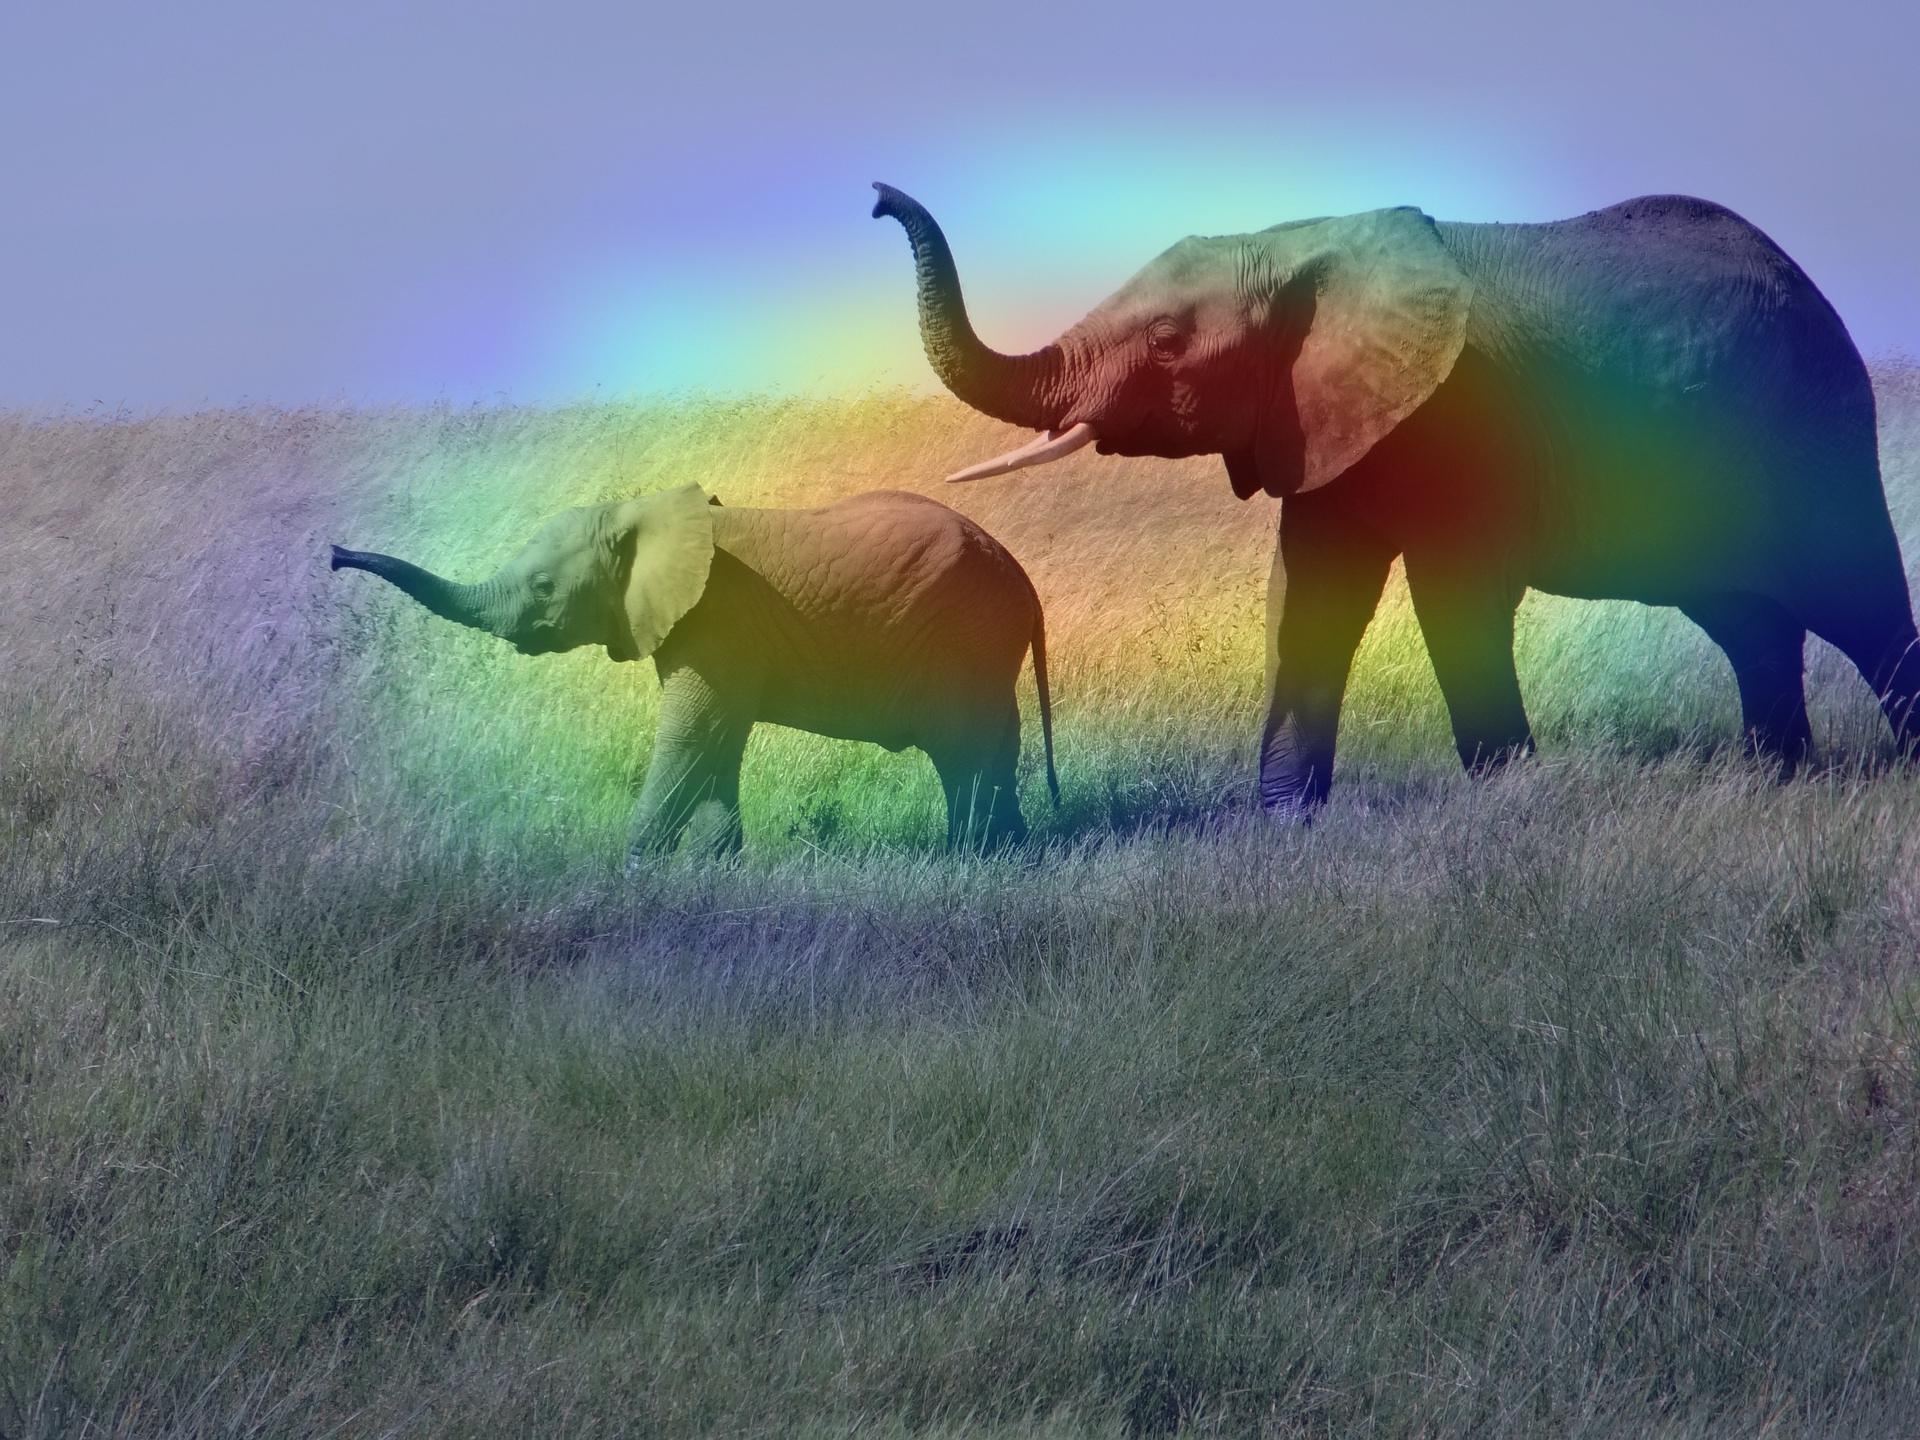

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
